In [1]:
import numpy as np
from copulas.univariate import GaussianKDE 
from copulas.bivariate import Clayton
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import pandas as pd
import random
from scipy.stats import genpareto
from scipy.stats import expon,poisson,pareto
import pathlib
import numpy as np
import pingouin as pg

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm 

from Utils_StochasticSimulation import *

C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#########################################################################
#
#----------------------Joint Simulation Algorithm --------------
#
#########################################################################

def prodInd(j,deltaMatrix):
    vectDelta_j = list(deltaMatrix[:,j])
    vectDelta_j.remove(vectDelta_j[j])
    return np.prod(np.array(vectDelta_j)<0)
def ComputeWk(k,deltaMatrix):
    K = deltaMatrix.shape[0]
    Delta = list(deltaMatrix[k,:])
    Delta.remove(Delta[k])
    Ind = [prodInd(j,deltaMatrix)  for j in range(K) if j != k]
    WwoE = np.dot(np.array(Delta),np.array(Ind))
    return WwoE

def DeltaMatrix(i,DELTA,K):
    deltaMatrix_i = np.zeros((K,K))
    deltaMatrix_i[0,1:] = DELTA.iloc[i,:]
    deltaMatrix_i[:,0] = - deltaMatrix_i[0,:] 
    for k in range(1,K):
        for l in range(k,K):
            if k != l:
                deltaMatrix_i[k,l] = deltaMatrix_i[0,l] - deltaMatrix_i[0,k]
                deltaMatrix_i[l,k] = -deltaMatrix_i[k,l]

    return deltaMatrix_i

## The following function define our joint simulation algorithm 
def simulation(sample,M,replacing=False):
    N,K = sample.shape
    DELTA = pd.DataFrame(columns=np.arange(K-1),index=np.arange(N))
    newSample = pd.DataFrame(columns=np.arange(K),index=np.arange(M))
    for k in range(0,K-1):
        DELTA.iloc[:,k] = sample.iloc[:,0] - sample.iloc[:,k+1]
    if replacing :
        Msample = DELTA.iloc[np.random.choice(list(np.arange(N)),M),:]
    else :
        Msample = DELTA.iloc[random.sample(list(np.arange(N)),M),:]
    E = expon.rvs(size=M)

    for m in range(M):
        deltaMatrix_m = DeltaMatrix(m,Msample,K)
        for k in range(K):
            newSample.iloc[m,k] = E[m] +  ComputeWk(k,deltaMatrix_m)
    return newSample



#########################################################################
#
#----------------------Conditional Simulation Algorithm --------------
#
#########################################################################


# Avec correction du 15/02
def CondSimulationExtremes(k,w,DeltaMatrix,ExcessStand,M):
    checkStep = []
    nDELTA,K = DeltaMatrix.shape
    Wk = np.zeros(M)
    if k != 0:
        w_wo_k = np.concatenate([w[0:k],w[k+1:]])
        kloc = 0
        idxDelta = k-1
    else:
        w_wo_k = w[1:]
        kloc =  (K+1) - 1
        idxDelta = k
    istar = np.argmax(w_wo_k) 
    istarAll = list(w).index(w_wo_k[istar])
    max_wo_k = np.max(w_wo_k)
    if max_wo_k > 0:
        
        if (istarAll == kloc): 
            checkStep.append(0)
        
            Tpos = set(list(np.arange(nDELTA)[np.delete(ExcessStand,k,1)[:,kloc]>0]))
            Tmax = set(list(np.arange(nDELTA)[np.argmax(np.delete(ExcessStand,k,1),axis=1)==kloc]))
            T = list(Tpos&Tmax)
            DELTAW1max = DeltaMatrix.iloc[T,:]
            Npos = DELTAW1max.shape[0]
            deltaSim = DELTAW1max.iloc[np.random.choice(list(np.arange(Npos)),M),idxDelta].values
            Wk = w[kloc] - deltaSim
        else :
            checkStep.append(1)
            
            for i in range(M):

                delta_star = w[kloc] - w_wo_k[istar]
                cond = True
                while cond:
                    delta_k = DeltaMatrix.iloc[np.random.choice(list(np.arange(nDELTA)),1),idxDelta].values[0]
                    u = stats.uniform.rvs()
                    cond = u > (np.exp(delta_k)*(delta_star>delta_k) + np.exp(delta_star)*(delta_star<delta_k))

                Wk[i] = w[kloc] - delta_k
    else:
        
        for i in tqdm(range(M)):
            checkStep.append(2)
            cond = True
            while cond:
                delta_k = DeltaMatrix.iloc[np.random.choice(list(np.arange(nDELTA)),1),idxDelta].values[0]
                u = stats.uniform.rvs()
                cond = u > (np.exp(delta_k)*(delta_k<w[kloc]))
            Wk[i] = w[kloc] - delta_k
    return Wk,checkStep

# I. Import Data 

In [3]:
def importData_txt(fileprice,filedates,name):
    path = r'C:\Users\nmadhar\Desktop\GANEV\MGPD\Data'
    
    prices = open(pathlib.PurePath(path, fileprice + '.txt'),'r')
    prices = prices.readlines()
    dates = open(pathlib.PurePath(path, filedates + '.txt'),'r')
    dates = dates.readlines()
    
    
    # Créer un dataframe à partir des lignes du fichier
    data = {name: [float(line.strip()) for line in prices]}
    df = pd.DataFrame(data)
    date = [line.strip() for line in dates]

    df.index = date
    return df



In [4]:
dfHSBC = importData_txt('HSBCW_Adj_Oct16','HSBCWDates_Adj_Oct16','HSBC')
dfLL = importData_txt('LloydsW_Adj_Oct16','LloydsWDates_Adj_Oct16','LL')
dfRBS = importData_txt('RBSW_Adj_Oct16','RBSWDates_Adj_Oct16','RBS')


In [5]:
datesHSBC = set(dfHSBC.index)
datesLL = set(dfLL.index)
datesRBS = set(dfRBS.index)

intersection_dates = list(datesHSBC.intersection(datesLL,datesRBS))
intersection_dates = pd.to_datetime(intersection_dates)
intersection_dates = intersection_dates.sort_values()[::-1]
intersection_dates = intersection_dates.strftime('%Y-%m-%d')


In [6]:
dfHSBC = dfHSBC.loc[intersection_dates,:]
dfLL = dfLL.loc[intersection_dates,:]
dfRBS = dfRBS.loc[intersection_dates,:]
#dfBar = dfBar.loc[intersection_dates,:]

In [7]:
Data = pd.DataFrame(columns=['HSBC','LL','RBS'])
Data.HSBC = dfHSBC.HSBC
Data.LL = dfLL.LL
Data.RBS = dfRBS.RBS
#Data.Bar = dfBar.Bar

Data.index = intersection_dates

In [8]:
DataReturns  = pd.DataFrame(columns=['HSBC','LL','RBS'])

DataReturns.HSBC = -(Data.HSBC.values[:-1]-Data.HSBC.values[1:])/Data.HSBC.values[1:] 
DataReturns.LL = -(Data.LL.values[:-1]-Data.LL.values[1:])/Data.LL.values[1:] 
DataReturns.RBS = -(Data.RBS.values[:-1]-Data.RBS.values[1:])/Data.RBS.values[1:] 


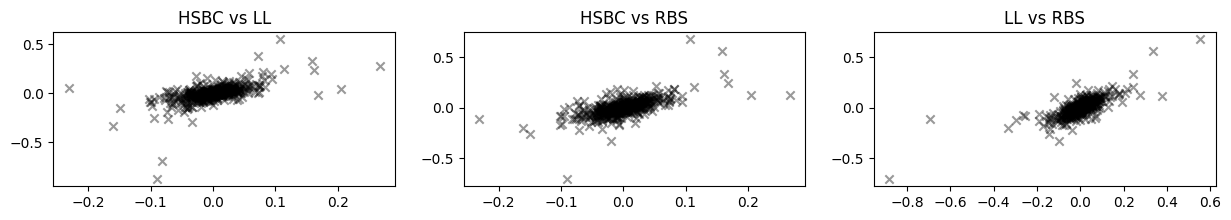

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 2))
ax[0].scatter(DataReturns.HSBC.values,DataReturns.LL,c='k',alpha=0.4,marker='x')
ax[0].set_title('HSBC vs LL')

ax[1].scatter(DataReturns.HSBC.values,DataReturns.RBS,c='k',alpha=0.4,marker='x')
ax[1].set_title('HSBC vs RBS')


ax[2].scatter(DataReturns.LL.values,DataReturns.RBS,c='k',alpha=0.4,marker='x')
ax[2].set_title('LL vs RBS')


plt.show()

# II. Marginal Fit 

In [10]:
nuHSBC,lHSBC,sHSBC = t.fit(DataReturns.HSBC.values)
nuLL,lLL,sLL = t.fit(DataReturns.LL.values)
nuRBS,lRBS,sRBS = t.fit(DataReturns.RBS.values)


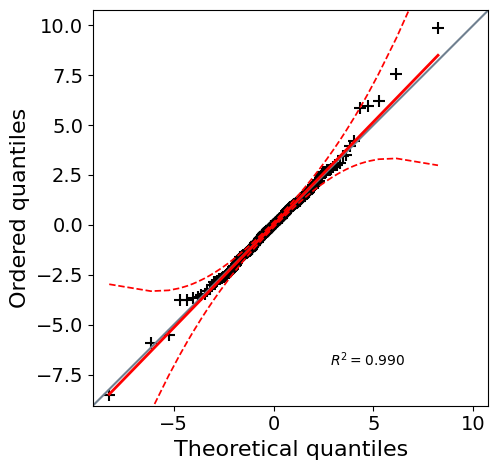

In [11]:

ax = pg.qqplot((DataReturns.HSBC.values-lHSBC)/sHSBC, dist="t", sparams=(nuHSBC,), confidence=.95,marker='+', color='k',s=80)
ax.set_xlabel('Theoretical quantiles',fontsize=16)
ax.set_ylabel('Ordered quantiles',fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()


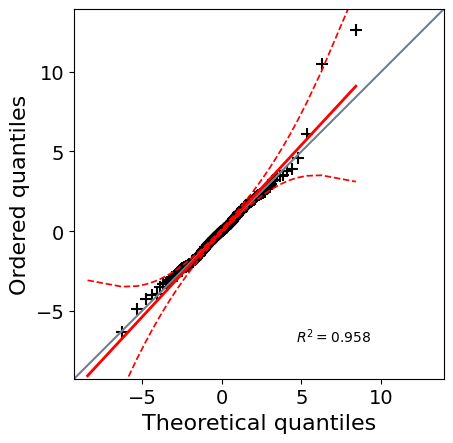

In [12]:
ax = pg.qqplot((DataReturns.RBS.values-lRBS)/sRBS, dist="t",sparams=(nuRBS,), confidence=.95,marker='+', color='k',s=80)
ax.set_xlabel('Theoretical quantiles',fontsize=16)
ax.set_ylabel('Ordered quantiles',fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)


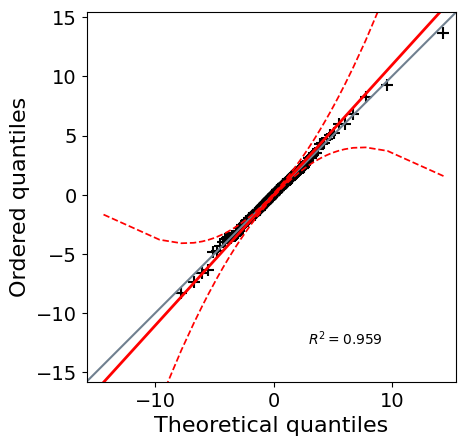

In [13]:
ax = pg.qqplot((DataReturns.LL.values-lLL)/sLL, dist="t", sparams=(nuLL,), confidence=.95,marker='+', color='k',s=80)

ax.set_xlabel('Theoretical quantiles',fontsize=16)
ax.set_ylabel('Ordered quantiles',fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)


# III. Data Processing
## 1. Transformation to uniform Scale

In [21]:
uHSBC = t.cdf(DataReturns.HSBC.values,loc=lHSBC,scale=sHSBC,df=nuHSBC)
uLL = t.cdf(DataReturns.LL.values,loc=lLL,scale=sLL,df=nuLL)
uRBS = t.cdf(DataReturns.RBS.values,loc=lRBS,scale=sRBS,df=nuRBS)


## 2. Transformation to Exponential Scale

In [22]:
e_HSBC = expon.ppf(uHSBC)
e_LL = expon.ppf(uLL)
e_RBS = expon.ppf(uRBS)
dfStand = pd.DataFrame(np.concatenate([e_HSBC.reshape(-1,1),e_LL.reshape(-1,1),e_RBS.reshape(-1,1)],axis=1))


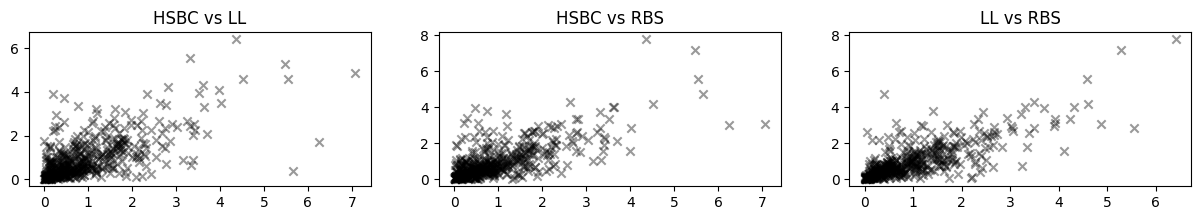

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 2))
ax[0].scatter(e_HSBC,e_LL,alpha=0.4,c='k',marker='x')
ax[0].set_title('HSBC vs LL')


ax[1].scatter(e_HSBC,e_RBS,alpha=0.4,c='k',marker='x')
ax[1].set_title('HSBC vs RBS')



ax[2].scatter(e_LL,e_RBS,alpha=0.4,c='k',marker='x')
ax[2].set_title('LL vs RBS')


# ax[2,0].scatter(e_LL,e_Bar,alpha=0.4,c='k',marker='x')
# ax[2,0].set_title('LL vs Bar')


# ax[2,1].scatter(e_RBS,e_Bar,alpha=0.4,c='k',marker='x')
# ax[2,1].set_title('RBS vs Bar')

plt.show()

## 3. Defining Excesses



In [28]:
alphaU = 0.83
t_HSBC = np.quantile(e_HSBC,alphaU)
t_LL = np.quantile(e_LL,alphaU)
t_RBS = np.quantile(e_RBS,alphaU)
n = len(e_HSBC)

In [31]:
TX0 = (np.arange(n)[dfStand.iloc[:,0]>t_HSBC]).reshape(-1,)
TY0 = (np.arange(n)[dfStand.iloc[:,1]>t_LL]).reshape(-1,)
TZ0 = (np.arange(n)[dfStand.iloc[:,2]>t_RBS]).reshape(-1,)

T0 = np.concatenate([TX0,TY0,TZ0])


T0 = np.array(list(OrderedDict.fromkeys(list(T0))),dtype=int)
ExcessStand = dfStand.iloc[T0,:]
ExcessStand.iloc[:,0] = ExcessStand.iloc[:,0] - t_HSBC
ExcessStand.iloc[:,1] = ExcessStand.iloc[:,1] - t_LL
ExcessStand.iloc[:,2] = ExcessStand.iloc[:,2] - t_RBS

ExcessStand = ExcessStand.values

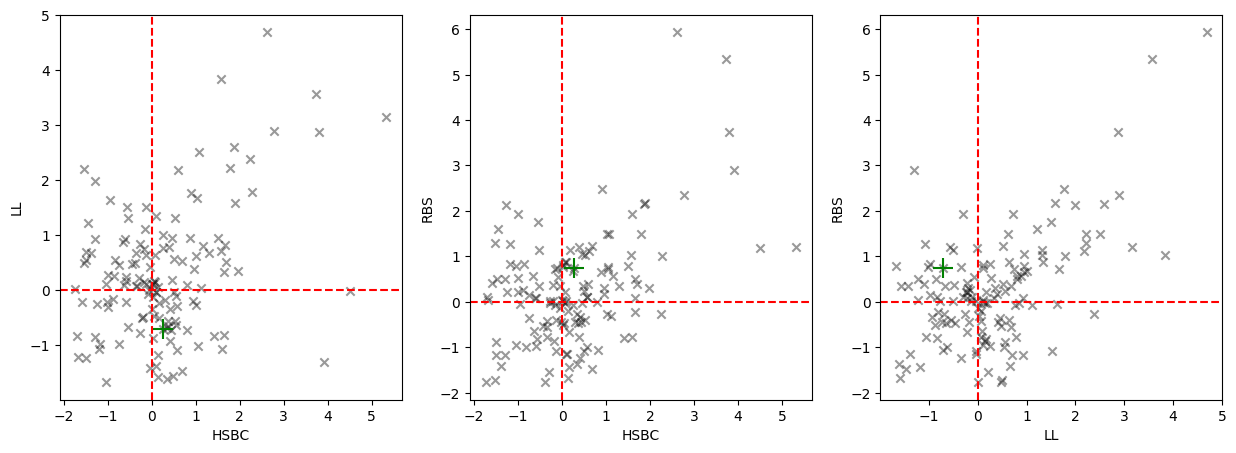

In [33]:
I = 20
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(ExcessStand[:,0],ExcessStand[:,1],alpha=0.4,marker='x',c='k')
ax[0].scatter(ExcessStand[I,0],ExcessStand[I,1],marker='+',c='green',s=200)
ax[0].axvline(0,linestyle='--',color='r')
ax[0].axhline(0,linestyle='--',color='r')
ax[0].set_xlabel('HSBC')
ax[0].set_ylabel('LL')

ax[1].scatter(ExcessStand[:,0],ExcessStand[:,2],alpha=0.4,marker='x',c='k')
ax[1].scatter(ExcessStand[I,0],ExcessStand[I,2],marker='+',c='green',s=200)
ax[1].axvline(0,linestyle='--',color='r')
ax[1].axhline(0,linestyle='--',color='r')
ax[1].set_xlabel('HSBC')
ax[1].set_ylabel('RBS')




ax[2].scatter(ExcessStand[:,1],ExcessStand[:,2],alpha=0.4,marker='x',c='k')
ax[2].scatter(ExcessStand[I,1],ExcessStand[I,2],marker='+',c='green',s=200)
ax[2].axvline(0,linestyle='--',color='r')
ax[2].axhline(0,linestyle='--',color='r')
ax[2].set_xlabel('LL')
ax[2].set_ylabel('RBS')



plt.show()

# IV. Joint Simulation
## 1. Excesses in Exponential Scale 

In [38]:
M = 10000
Simd4 = simulation(pd.DataFrame(ExcessStand),M,True)
ExcessSim = Simd4.values


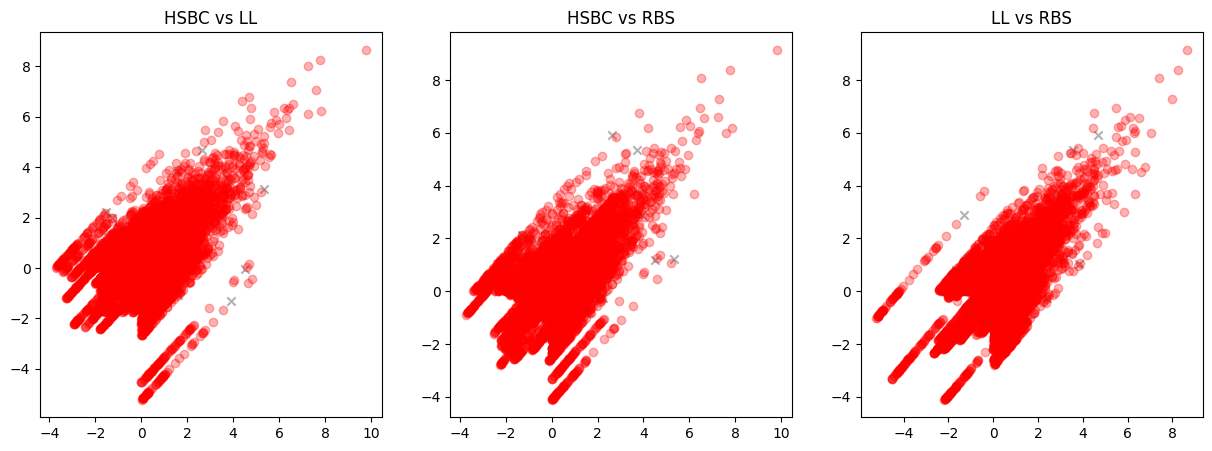

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(ExcessStand[:,0],ExcessStand[:,1],c='k',marker='x',alpha=0.3)
ax[0].scatter(ExcessSim[:,0],ExcessSim[:,1],c='r',marker='o',alpha=0.3)
ax[0].set_title('HSBC vs LL')

ax[1].scatter(ExcessStand[:,0],ExcessStand[:,2],c='k',marker='x',alpha=0.3)
ax[1].scatter(ExcessSim[:,0],ExcessSim[:,2],c='r',marker='o',alpha=0.3)
ax[1].set_title('HSBC vs RBS')


ax[2].scatter(ExcessStand[:,1],ExcessStand[:,2],c='k',marker='x',alpha=0.3)
ax[2].scatter(ExcessSim[:,1],ExcessSim[:,2],c='r',marker='o',alpha=0.3)
ax[2].set_title('LL vs RBS')




plt.show()

In [40]:
alphaVect = np.linspace(0.01,0.99,100)


ExcessSimPos = ExcessSim[ExcessSim[:,0]>0,0] 
ExcessStandPos = ExcessStand[ExcessStand[:,0]>0,0]

alphaN = np.array(len(ExcessSimPos)*alphaVect,dtype=int)
alphaM = np.array(len(ExcessStandPos)*alphaVect,dtype=int)
rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_HSBC,dtype=float)),loc=lHSBC,scale=sHSBC,df=nuHSBC)
rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_HSBC,dtype=float)),loc=lHSBC,scale=sHSBC,df=nuHSBC)


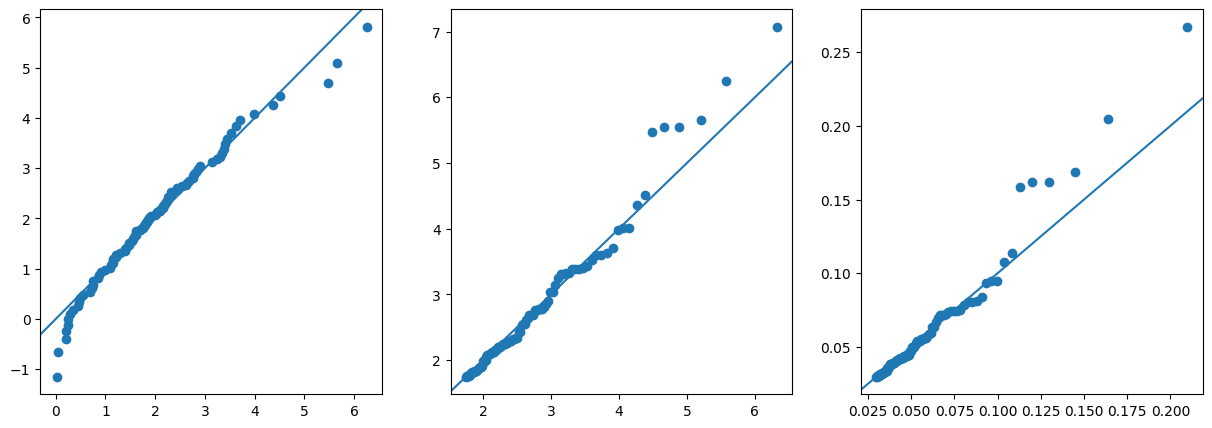

In [41]:
n = ExcessStand.shape[0]
alphaVect = np.linspace(0.01,0.99,100)
alphaN = np.array(n*alphaVect,dtype=int)
alphaM = np.array(M*alphaVect,dtype=int)



fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(np.sort(ExcessStand[:,0]+t_HSBC)[alphaN],(np.sort(ExcessSim[:,0]+t_HSBC))[alphaM])
ax[0].axline((0, 0), slope=1)

alphaN = np.array(len(ExcessSimPos)*alphaVect,dtype=int)
alphaM = np.array(len(ExcessStandPos)*alphaVect,dtype=int)

ax[1].scatter(np.sort(ExcessSimPos+t_HSBC)[alphaN],(np.sort(ExcessStandPos+t_HSBC))[alphaM])
ax[1].axline((2, 2), slope=1)


rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_HSBC,dtype=float)),loc=lHSBC,scale=sHSBC,df=nuHSBC)
rhsbcPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_HSBC,dtype=float)),loc=lHSBC,scale=sHSBC,df=nuHSBC)


ax[2].scatter(np.sort(rSimPos)[alphaN],(np.sort(rhsbcPos))[alphaM])
ax[2].axline((0.05, 0.05), slope=1)


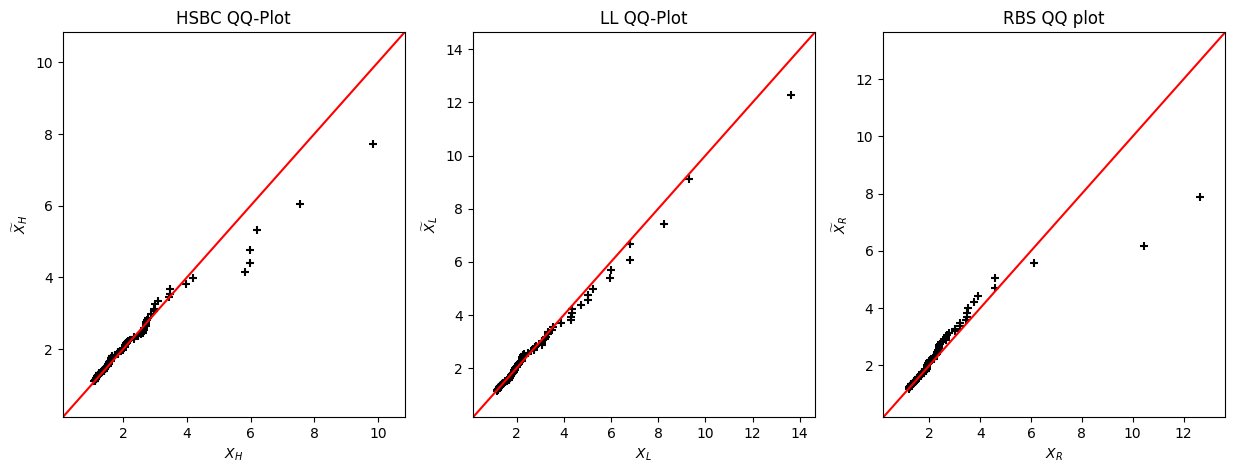

In [46]:
#################################################################################################################
#
#--------------------------------------- HSBC QQPlot simu vs Observed --------------------------------------------
#
##################################################################################################################


fig, ax = plt.subplots(1, 3, figsize=(15,5))

ExcessSimPos = ExcessSim[ExcessSim[:,0]>0,0] 
ExcessStandPos = ExcessStand[ExcessStand[:,0]>0,0]

alphaN = np.array(len(ExcessSimPos)*alphaVect,dtype=int)
alphaM = np.array(len(ExcessStandPos)*alphaVect,dtype=int)


# rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_HSBC,dtype=float)),loc=lHSBC,scale=sHSBC,df=nuHSBC)
# rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_HSBC,dtype=float)),loc=lHSBC,scale=sHSBC,df=nuHSBC)

rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_HSBC,dtype=float)),df=nuHSBC)
rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_HSBC,dtype=float)),df=nuHSBC)


xmin = (np.sort(rPos))[alphaM].min()-1
xmax = (np.sort(rPos))[alphaM].max()+1

ymin = np.sort(rSimPos)[alphaN].min()-1
ymax = np.sort(rSimPos)[alphaN].max()+1

ax[0].scatter((np.sort(rPos))[alphaM],np.sort(rSimPos)[alphaN],marker='+',color='k')
ax[0].set_xlim(min(xmin,ymin), max(xmax,ymax))
ax[0].set_ylim(min(xmin,ymin), max(xmax,ymax))
ax[0].set_xlabel('$X_H$')
ax[0].set_ylabel(r'$\widetilde{X}_H$')

ax[0].axline((0.05, 0.05), slope=1,c='r')
ax[0].set_title('HSBC QQ-Plot')


#################################################################################################################
#
#--------------------------------------- LL QQPlot simu vs Observed --------------------------------------------
#
##################################################################################################################



ExcessSimPos = ExcessSim[ExcessSim[:,1]>0,1] 
ExcessStandPos = ExcessStand[ExcessStand[:,1]>0,1]

alphaN = np.array(len(ExcessSimPos)*alphaVect,dtype=int)
alphaM = np.array(len(ExcessStandPos)*alphaVect,dtype=int)


# rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_LL,dtype=float)),loc=lLL,scale=sLL,df=nuLL)
# rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_LL,dtype=float)),loc=lLL,scale=sLL,df=nuLL)

rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_LL,dtype=float)),df=nuLL)
rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_LL,dtype=float)),df=nuLL)


xmin = (np.sort(rPos))[alphaM].min()-1
xmax = (np.sort(rPos))[alphaM].max()+1

ymin = np.sort(rSimPos)[alphaN].min()-1
ymax = np.sort(rSimPos)[alphaN].max()+1

ax[1].scatter((np.sort(rPos))[alphaM],np.sort(rSimPos)[alphaN],marker='+',color='k')
ax[1].set_xlim(min(xmin,ymin), max(xmax,ymax))
ax[1].set_ylim(min(xmin,ymin), max(xmax,ymax))
ax[1].set_xlabel('$X_L$')
ax[1].set_ylabel(r'$\widetilde{X}_L$')

ax[1].axline((0.05, 0.05), slope=1,c='r')
ax[1].set_title('LL QQ-Plot')

#################################################################################################################
#
#--------------------------------------- RBS QQPlot simu vs Observed --------------------------------------------
#
##################################################################################################################



ExcessSimPos = ExcessSim[ExcessSim[:,2]>0,2] 
ExcessStandPos = ExcessStand[ExcessStand[:,2]>0,2]

alphaN = np.array(len(ExcessSimPos)*alphaVect,dtype=int)
alphaM = np.array(len(ExcessStandPos)*alphaVect,dtype=int)


# rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_RBS,dtype=float)),loc=lRBS,scale=sRBS,df=nuRBS)
# rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_RBS,dtype=float)),loc=lRBS,scale=sRBS,df=nuRBS)

rSimPos = t.ppf(expon.cdf(np.array(ExcessSimPos+t_RBS,dtype=float)),df=nuRBS)
rPos = t.ppf(expon.cdf(np.array(ExcessStandPos+t_RBS,dtype=float)),df=nuRBS)

xmin = (np.sort(rPos))[alphaM].min()-1
xmax = (np.sort(rPos))[alphaM].max()+1

ymin = np.sort(rSimPos)[alphaN].min()-1
ymax = np.sort(rSimPos)[alphaN].max()+1

ax[2].scatter((np.sort(rPos))[alphaM],np.sort(rSimPos)[alphaN],marker='+',color='k')
ax[2].axline((0.05, 0.05), slope=1,c='r')
ax[2].set_xlim(min(xmin,ymin), max(xmax,ymax))
ax[2].set_xlabel('$X_R$')
ax[2].set_ylabel(r'$\widetilde{X}_R$')
ax[2].set_ylim(min(xmin,ymin), max(xmax,ymax))


ax[2].set_title('RBS QQ plot')

plt.show()



## 2. Backward Tranformation to original scale 

In [47]:
eSim_HSBC = ExcessSim[:,0] + t_HSBC
eSim_LL = ExcessSim[:,1] + t_LL
eSim_RBS = ExcessSim[:,2] + t_RBS


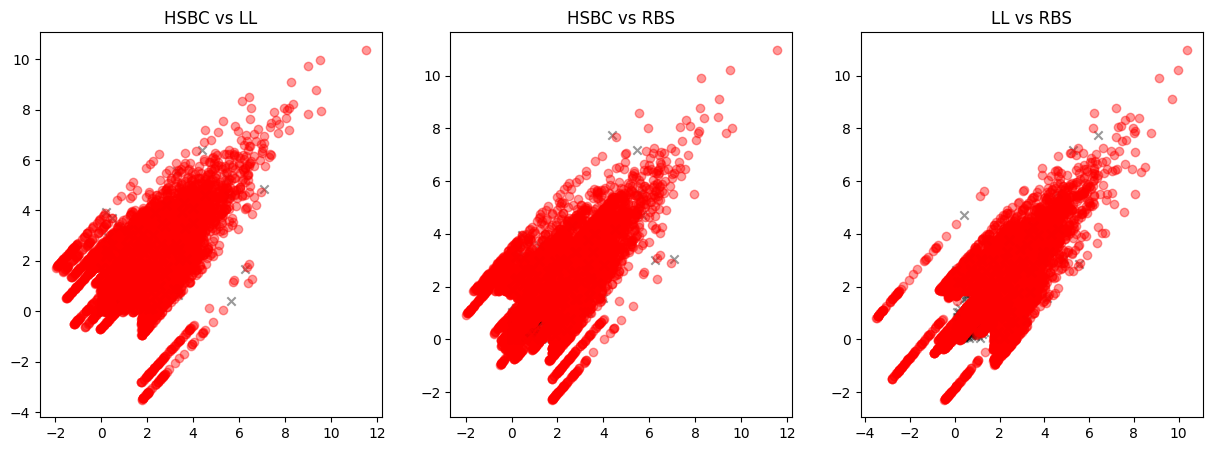

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(e_HSBC,e_LL,alpha=0.4,c='k',marker='x')
ax[0].scatter(eSim_HSBC,eSim_LL,alpha=0.4,c='r',marker='o')

ax[0].set_title('HSBC vs LL')


ax[1].scatter(e_HSBC,e_RBS,alpha=0.4,c='k',marker='x')
ax[1].scatter(eSim_HSBC,eSim_RBS,alpha=0.4,c='r',marker='o')
ax[1].set_title('HSBC vs RBS')



ax[2].scatter(e_LL,e_RBS,alpha=0.4,c='k',marker='x')
ax[2].scatter(eSim_LL,eSim_RBS,alpha=0.4,c='r',marker='o')
ax[2].set_title('LL vs RBS')




plt.show()

In [50]:
uSim_HSBC = expon.cdf(np.array(eSim_HSBC,dtype=float))
uSim_LL = expon.cdf(np.array(eSim_LL,dtype=float))
uSim_RBS = expon.cdf(np.array(eSim_RBS,dtype=float))


In [51]:
rSim_HSBC = t.ppf(uSim_HSBC,loc=lHSBC,scale=sHSBC,df=nuHSBC)
rSim_LL = t.ppf(uSim_LL,loc=lLL,scale=sLL,df=nuLL)
rSim_RBS = t.ppf(uSim_RBS,loc=lRBS,scale=sRBS,df=nuRBS)


In [52]:
dfSim = pd.DataFrame(columns=['HSBC','LL','RBS','Bar'])
dfSim = pd.DataFrame(columns=['HSBC','LL','RBS'])

dfSim.HSBC = rSim_HSBC
dfSim.LL = rSim_LL
dfSim.RBS = rSim_RBS


---
# A. Tail risk metrics estimation with joint simulation algorithm 

---

In [54]:
alphaVaR = 0.9975
VaRHSBC = t.ppf(alphaVaR,df=nuHSBC,loc=lHSBC,scale=sHSBC)
VaRLL = t.ppf(alphaVaR,df=nuLL,loc=lLL,scale=sLL)
VaRRBS = t.ppf(alphaVaR,df=nuRBS,loc=lRBS,scale=sRBS)

## 1. One shoot estimation
### 1. ES Estimation 

In [55]:
ES_Emp_HSBC = np.mean(DataReturns.HSBC.values[DataReturns.HSBC.values>VaRHSBC])
ES_Emp_LL = np.mean(DataReturns.LL.values[DataReturns.LL.values>VaRLL])
ES_Emp_RBS = np.mean(DataReturns.RBS.values[DataReturns.RBS.values>VaRRBS])

ES_Simu_HSBC = np.mean(dfSim.HSBC.values[dfSim.HSBC.values>VaRHSBC])
ES_Simu_LL = np.mean(dfSim.LL.values[dfSim.LL.values>VaRLL])
ES_Simu_RBS = np.mean(dfSim.RBS.values[dfSim.RBS.values>VaRRBS])

ES_t_HSBC = lHSBC + sHSBC*((nuHSBC+t.ppf(alphaVaR,df=nuHSBC)**2)/((nuHSBC-1)*(1-alphaVaR)) * t.pdf(t.ppf(alphaVaR,df= nuHSBC),df=nuHSBC))
ES_t_LL = lLL+ sLL*((nuLL+t.ppf(alphaVaR,df=nuLL)**2)/((nuLL-1)*(1-alphaVaR)) * t.pdf(t.ppf(alphaVaR,df= nuLL),df=nuLL))
ES_t_RBS = lRBS + sRBS*((nuRBS+t.ppf(alphaVaR,df=nuRBS)**2)/((nuRBS-1)*(1-alphaVaR)) * t.pdf(t.ppf(alphaVaR,df= nuRBS),df=nuRBS))

### 2. DCTE Estimation

In [56]:
n = len(DataReturns.HSBC.values)
THSBC = set(np.arange(n)[DataReturns.HSBC.values>VaRHSBC])
TLL = set(np.arange(n)[DataReturns.LL.values>VaRLL])
TRBS = set(np.arange(n)[DataReturns.RBS.values>VaRRBS])
T_dcte = list(THSBC&TLL&TRBS)


In [57]:
n = len(DataReturns.HSBC.values)
THSBC = set(np.arange(n)[DataReturns.HSBC.values>VaRHSBC])
TLL = set(np.arange(n)[DataReturns.LL.values>VaRLL])
TRBS = set(np.arange(n)[DataReturns.RBS.values>VaRRBS])
T_dcte = list(THSBC&TLL&TRBS)

DE_HSBC = np.mean(DataReturns.HSBC.values[T_dcte])
DE_LL = np.mean(DataReturns.LL.values[T_dcte])
DE_RBS = np.mean(DataReturns.RBS.values[T_dcte])
DE_HSBC,DE_LL,DE_RBS


C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan, nan)

In [58]:
nSimu = len(dfSim.HSBC.values)
THSBC = set(np.arange(nSimu)[dfSim.HSBC.values>VaRHSBC])
TLL = set(np.arange(nSimu)[dfSim.LL.values>VaRLL])
TRBS = set(np.arange(nSimu)[dfSim.RBS.values>VaRRBS])
T_dcte_simu = list(THSBC&TLL&TRBS)

DE_Simu_HSBC = np.mean(dfSim.HSBC.values[T_dcte_simu])
DE_Simu_LL = np.mean(dfSim.LL.values[T_dcte_simu])
DE_Simu_RBS = np.mean(dfSim.RBS.values[T_dcte_simu])

DE_Simu_HSBC,DE_Simu_LL,DE_Simu_RBS


(0.32903345175229576, 0.9954911039372043, 0.6424577897423989)

### 3. MES Estimation 

In [59]:
n = len(DataReturns.HSBC.values)
THSBC = set(np.arange(n)[DataReturns.HSBC.values>VaRHSBC])
TLL = set(np.arange(n)[DataReturns.LL.values>VaRLL])
TRBS = set(np.arange(n)[DataReturns.RBS.values>VaRRBS])
T_MES_HSBC = list(TLL&TRBS)
T_MES_LL = list(THSBC&TRBS)
T_MES_RBS = list(TLL&THSBC)


MES_HSBC = np.mean(DataReturns.HSBC.values[T_MES_HSBC])
MES_LL = np.mean(DataReturns.LL.values[T_MES_LL])
MES_RBS = np.mean(DataReturns.RBS.values[T_MES_RBS])
MES_HSBC,MES_LL,MES_RBS


(0.10763451998398234, nan, nan)

In [60]:
nSimu = len(dfSim.HSBC.values)
THSBC = set(np.arange(nSimu)[dfSim.HSBC.values>VaRHSBC])
TLL = set(np.arange(nSimu)[dfSim.LL.values>VaRLL])
TRBS = set(np.arange(nSimu)[dfSim.RBS.values>VaRRBS])
T_MES_HSBC_simu = list(TLL&TRBS)
T_MES_LL_simu = list(THSBC&TRBS)
T_MES_RBS_simu = list(TLL&THSBC)

MES_Simu_HSBC = np.mean(dfSim.HSBC.values[T_MES_HSBC_simu])
MES_Simu_LL = np.mean(dfSim.LL.values[T_MES_LL_simu])
MES_Simu_RBS = np.mean(dfSim.RBS.values[T_MES_RBS_simu])

MES_Simu_HSBC,MES_Simu_LL,MES_Simu_RBS



(0.29087545720811336, 0.8863107920721945, 0.586891235534878)

In [61]:
dfTRM = pd.DataFrame(columns=['Max','VaR t','ES Emp','ES t','ES Simu','DCTE Emp','DCTE Simu','MES Emp','MES Simu'],index=['HSBC','LL','RBS'])
dfTRM['Max'] = [DataReturns.HSBC.values.max(),DataReturns.LL.values.max(),DataReturns.RBS.values.max()]

dfTRM['VaR t'] = [VaRHSBC,VaRLL,VaRRBS]
dfTRM['ES Emp'] = [ES_Emp_HSBC,ES_Emp_LL,ES_Emp_RBS]
dfTRM['ES t'] = [ES_t_HSBC,ES_t_LL,ES_t_RBS]
dfTRM['ES Simu'] = [ES_Simu_HSBC,ES_Simu_LL,ES_Simu_RBS]
dfTRM['DCTE Emp'] = [DE_HSBC,DE_LL,DE_RBS]
dfTRM['DCTE Simu'] = [DE_Simu_HSBC,DE_Simu_LL,DE_Simu_RBS]
dfTRM['MES Emp'] = [MES_HSBC,MES_LL,MES_RBS]
dfTRM['MES Simu'] = [MES_Simu_HSBC,MES_Simu_LL,MES_Simu_RBS]
dfTRM

,Max,VaR t,ES Emp,ES t,ES Simu,DCTE Emp,DCTE Simu,MES Emp,MES Simu
HSBC,0.267241,0.188143,0.236035,0.277249,0.269062,NaN,0.329033,0.107635,0.290875
LL,0.553226,0.459727,0.553226,0.829724,0.811004,NaN,0.995491,NaN,0.886311
RBS,0.676498,0.379616,0.618552,0.562478,0.563084,NaN,0.642458,NaN,0.586891


## 2. TRM estimation through multiple runs 

In [62]:
VaRHSBC = t.ppf(alphaVaR,df=nuHSBC,loc=lHSBC,scale=sHSBC)
VaRLL = t.ppf(alphaVaR,df=nuLL,loc=lLL,scale=sLL)
VaRRBS = t.ppf(alphaVaR,df=nuRBS,loc=lRBS,scale=sRBS)

def getEstimateTRMK3s(VaR,df):
    n,K = df.shape
    T = {}
    for k in range(K):
        T[str(k)] = set(np.arange(n)[df.iloc[:,k]>VaR[k]])
    
    T_dcte = list(T[str(0)]&T[str(1)]&T[str(2)])
    T_mes = [list(T[str(1)]&T[str(2)]),list(T[str(0)]&T[str(2)]),list(T[str(0)]&T[str(1)])]
    
    ES,MES,DCTE = np.zeros(K),np.zeros(K),np.zeros(K)
    
    for i in range(K):
        ES[i] = np.mean(df.iloc[:,i].values[df.iloc[:,i].values>VaR[i]])
        MES[i] = np.mean(df.iloc[T_mes[i],i])
        DCTE[i] = np.mean(df.iloc[T_dcte,i])

    return ES,MES,DCTE
    
Q = 1000
VaRt = [VaRHSBC,VaRLL,VaRRBS]
ES_Emp,MES_Emp,DCTE_Emp = getEstimateTRMK3s(VaRt,DataReturns)
#ES_Simu,MES_Simu,DCTE_Simu = getEstimateTRMK3s(VaRt,dfSim)
dfTRMS = pd.DataFrame(columns =['ES Simu','MES Simu','DCTE Simu','Stock'],index=np.arange(Q*3))




In [66]:
for i in tqdm(range(Q)):
    ExcessSim = simulation(pd.DataFrame(ExcessStand),M,True).values


    eSim_HSBC = ExcessSim[:,0] + t_HSBC
    eSim_LL = ExcessSim[:,1] + t_LL
    eSim_RBS = ExcessSim[:,2] + t_RBS


    uSim_HSBC = expon.cdf(np.array(eSim_HSBC,dtype=float))
    uSim_LL = expon.cdf(np.array(eSim_LL,dtype=float))
    uSim_RBS = expon.cdf(np.array(eSim_RBS,dtype=float))

    rSim_HSBC = t.ppf(uSim_HSBC,loc=lHSBC,scale=sHSBC,df=nuHSBC)
    rSim_LL = t.ppf(uSim_LL,loc=lLL,scale=sLL,df=nuLL)
    rSim_RBS = t.ppf(uSim_RBS,loc=lRBS,scale=sRBS,df=nuRBS)


    dfSim = pd.DataFrame(columns=['HSBC','LL','RBS'])

    dfSim.HSBC = rSim_HSBC
    dfSim.LL = rSim_LL
    dfSim.RBS = rSim_RBS


    getEstimateTRMK3s(VaRt,dfSim)
    ES_Simu,MES_Simu,DCTE_Simu = getEstimateTRMK3s(VaRt,dfSim)

    dfTRMS.iloc[i*3:(i+1)*3,0] = ES_Simu 
    dfTRMS.iloc[i*3:(i+1)*3,1] = MES_Simu 
    dfTRMS.iloc[i*3:(i+1)*3,2] = DCTE_Simu 
    dfTRMS.iloc[i*3:(i+1)*3,3] = ['HSBC','LL','RBS'] 

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:05:41<00:00,  3.91s/it]


In [67]:
display(dfTRMS.groupby(['Stock']).mean()),display(dfTRMS.groupby(['Stock']).std())

,ES Simu,MES Simu,DCTE Simu
Stock,,,
HSBC,0.277435,0.286679,0.324470
LL,0.831413,0.923007,1.042804
RBS,0.563477,0.620284,0.665131


,ES Simu,MES Simu,DCTE Simu
Stock,,,
HSBC,0.015409,0.023133,0.026985
LL,0.096463,0.144725,0.172657
RBS,0.030652,0.052116,0.057469


(None, None)

---
# B. Conditional Expectation inference with conditional simulation algorithm

---

In [68]:
def caliReg(data,regressors,k):
    dfTrain,dfTest = data.iloc[:200,:].values,data.iloc[200:,:].values

    reg = linear_model.LinearRegression()
    reg.fit(dfTrain[:,regressors], dfTrain[:,k])

    YTpred = reg.predict(dfTrain[:,regressors])
    ytpred = reg.predict(dfTest[:,regressors])

    MSETrain = mean_squared_error(dfTrain[:,k], YTpred)
    RMSETrain = np.sqrt(MSETrain)
    print(f'R2 Train = ',r2_score(dfTrain[:,k],YTpred))
    return reg 

M = 10000

## $\mathbb{E}[X_H | X = x]$

In [71]:
regH = caliReg(DataReturns,[1,2],0)

R2 Train =  0.3501601793521243


### a. $w_{\star}=w_1$  


In [72]:
alphaShock = 0.997
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(alphaShock) - t_RBS
Q = 100

In [73]:
eH_shock,eL_shock,eR_shock

(4.067362977455294, 4.091769309858403, 3.9790521101025558)

In [76]:
ExcessStandH = ExcessStand[:,[1,0,2]]
nStand,K = ExcessStandH.shape
DELTA_1 = pd.DataFrame(columns=np.arange(K-1),index=np.arange(nStand))
for k in range(0,K-1):
    DELTA_1.iloc[:,k] = ExcessStandH[:,0] - ExcessStandH[:,k+1]
    

mH_1 = []
zobs = [eL_shock,eH_shock,eR_shock]
print(zobs)

for q in tqdm(range(Q)):
    ZCOndHSBC,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandH,M)


    uCond_HSBC = expon.cdf(np.array(ZCOndHSBC+t_HSBC,dtype=float))
    rCond_HSBC = t.ppf(uCond_HSBC,loc=lHSBC,scale=sHSBC,df=nuHSBC)

    inf_rows = rCond_HSBC==-np.inf
    rCond_HSBC = rCond_HSBC[~inf_rows]
    mH_1.append(np.mean(rCond_HSBC))


[4.091769309858403, 4.067362977455294, 3.9790521101025558]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.51it/s]


In [77]:
np.mean(mH_1),np.std(mH_1),DataReturns.HSBC.max()

(0.15268193840548322, 0.0005933754186852481, 0.26724134837827757)

In [78]:
xl,xR = t.ppf(alphaShock,loc=lLL,scale=sLL,df=nuLL),t.ppf(alphaShock,loc=lRBS,scale=sRBS,df=nuRBS)
shockLR_H_1 = regH.predict(np.array([xl,xR]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_H_1,4)}')

Shock Calibrated with LR 0.1481


### b.  $w_{\star}=w_3$  


In [37]:
alphaShock = 0.99
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(0.995) - t_RBS
[eL_shock,eH_shock,eR_shock]

[2.8877965055324673, 2.863390173129358, 3.4682264863365644]

In [38]:
mH_2 = []
zobs = [eL_shock,eH_shock,eR_shock]
print(zobs)
for q in tqdm(range(Q)):
    ZCOndHSBC,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandH,M)


    uCond_HSBC = expon.cdf(np.array(ZCOndHSBC+t_HSBC,dtype=float))
    rCond_HSBC = t.ppf(uCond_HSBC,loc=lHSBC,scale=sHSBC,df=nuHSBC)

    inf_rows = rCond_HSBC==-np.inf
    rCond_HSBC = rCond_HSBC[~inf_rows]
    mH_2.append(np.mean(rCond_HSBC))


[2.8877965055324673, 2.863390173129358, 3.4682264863365644]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.65s/it]


In [39]:
np.mean(mH_2),np.std(mH_2),DataReturns.HSBC.max()

(0.10938337092583866, 0.0004061516024921377, 0.26724134837827757)

In [40]:
xl,xR = t.ppf(alphaShock,loc=lLL,scale=sLL,df=nuLL),t.ppf(0.995,loc=lRBS,scale=sRBS,df=nuRBS)
shockLR_H_2 = regH.predict(np.array([xl,xR]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_H_2,4)}')

Shock Calibrated with LR 0.1051


### c.  $w_{\star}=w_2$  


In [42]:
alphaShock = 0.80
eH_shock = expon.ppf(0.9) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(alphaShock) - t_RBS
[eL_shock,eH_shock,eR_shock]

[-0.10793576802152338, 0.560805080135313, -0.22065296777737076]

In [43]:
mH_3 = []

zobs = [eL_shock,eH_shock,eR_shock]
print(zobs)
for q in range(Q):
    ZCOndHSBC,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandH,M)


    uCond_HSBC = expon.cdf(np.array(ZCOndHSBC+t_HSBC,dtype=float))
    rCond_HSBC = t.ppf(uCond_HSBC,loc=lHSBC,scale=sHSBC,df=nuHSBC)

    inf_rows = rCond_HSBC==-np.inf
    rCond_HSBC = rCond_HSBC[~inf_rows]
    mH_3.append(np.mean(rCond_HSBC))


[-0.10793576802152338, 0.560805080135313, -0.22065296777737076]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 966.28it/s]


In [44]:
np.mean(mH_3),np.std(mH_3),DataReturns.HSBC.max()

(0.04361669920554966, 0.0001369888196262322, 0.26724134837827757)

In [45]:
xl,xR = t.ppf(alphaShock,loc=lLL,scale=sLL,df=nuLL),t.ppf(alphaShock,loc=lRBS,scale=sRBS,df=nuRBS)
shockLR_H_3 = regH.predict(np.array([xl,xR]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_H_3,4)}')

Shock Calibrated with LR 0.0187


## $\mathbb{E}[X_L | X = x]$

In [46]:
regL = caliReg(DataReturns,[0,2],1)

R2 Train =  0.4897469187013661


### a. $w_{\star}=w_1$  


In [47]:
alphaShock = 0.997
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(alphaShock) - t_RBS


In [48]:
ExcessStandL = ExcessStand[:,[0,1,2]]
nStand,K = ExcessStandL.shape

DELTA_1 = pd.DataFrame(columns=np.arange(K-1),index=np.arange(nStand))
for k in range(0,K-1):
    DELTA_1.iloc[:,k] = ExcessStandL[:,0] - ExcessStandL[:,k+1]
    

mL_1 = []
zobs = [eH_shock,eL_shock,eR_shock]
print(zobs)
for q in tqdm(range(Q)):
    ZCOndLL,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandL,M)

    uCond_LL = expon.cdf(np.array(ZCOndLL+t_LL,dtype=float))
    rCond_LL = t.ppf(uCond_LL,loc=lLL,scale=sLL,df=nuLL)

    inf_rows = rCond_LL==-np.inf
    rCond_LL = rCond_LL[~inf_rows]
    mL_1.append(np.mean(rCond_LL))


[4.067362977455294, 4.091769309858403, 3.9790521101025558]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.50it/s]


In [49]:
np.mean(mL_1),np.std(mL_1),DataReturns.LL.max()

(0.30307121941246534, 0.001807072639096569, 0.5532257906020824)

In [50]:
xh,xR = t.ppf(alphaShock,loc=lHSBC,scale=sHSBC,df=nuHSBC),t.ppf(alphaShock,loc=lRBS,scale=sRBS,df=nuRBS)
shockLR_L_1 = regL.predict(np.array([xh,xR]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_L_1,4)}')

Shock Calibrated with LR 0.2042


### b. $w_{\star}=w_3$  


In [51]:
alphaShock = 0.90
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(0.995) - t_RBS
[eH_shock,eL_shock,eR_shock]

[0.560805080135313, 0.585211412538422, 3.4682264863365644]

In [52]:
mL_2 = []
zobs = [eH_shock,eL_shock,eR_shock]
print(zobs)
for q in tqdm(range(Q)):
    ZCOndLL,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandL,M)

    uCond_LL = expon.cdf(np.array(ZCOndLL+t_LL,dtype=float))
    rCond_LL = t.ppf(uCond_LL,loc=lLL,scale=sLL,df=nuLL)

    inf_rows = rCond_LL==-np.inf
    rCond_LL = rCond_LL[~inf_rows]
    mL_2.append(np.mean(rCond_LL))


[0.560805080135313, 0.585211412538422, 3.4682264863365644]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:25<00:00, 40.06s/it]


In [53]:
np.mean(mL_2),np.std(mL_2),DataReturns.LL.max()

(0.08799647281753989, 0.000784897443621135, 0.5532257906020824)

In [54]:
xh,xR = t.ppf(alphaShock,loc=lHSBC,scale=sHSBC,df=nuHSBC),t.ppf(0.995,loc=lRBS,scale=sRBS,df=nuRBS)
shockLR_L_2 = regL.predict(np.array([xh,xR]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_L_2,4)}')

Shock Calibrated with LR 0.1417


### c. $w_{\star}=w_2$  


In [55]:
alphaShock = 0.80
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(0.9) - t_LL
eR_shock = expon.ppf(alphaShock) - t_RBS
[eH_shock,eL_shock,eR_shock]

[-0.13234210042463235, 0.585211412538422, -0.22065296777737076]

In [56]:
mL_3 = []
zobs = [eH_shock,eL_shock,eR_shock]
print(zobs)

for q in range(Q):
    ZCOndLL,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandL,M)

    uCond_LL = expon.cdf(np.array(ZCOndLL+t_LL,dtype=float))
    rCond_LL = t.ppf(uCond_LL,loc=lLL,scale=sLL,df=nuLL)

    inf_rows = rCond_LL==-np.inf
    rCond_LL = rCond_LL[~inf_rows]
    mL_3.append(np.mean(rCond_LL))


[-0.13234210042463235, 0.585211412538422, -0.22065296777737076]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 889.87it/s]


In [57]:
np.mean(mL_3),np.std(mL_3),DataReturns.LL.max()

(0.07934607305932201, 0.0002884595218808015, 0.5532257906020824)

In [58]:
xh,xR = t.ppf(alphaShock,loc=lHSBC,scale=sHSBC,df=nuHSBC),t.ppf(alphaShock,loc=lRBS,scale=sRBS,df=nuRBS)
shockLR_H_3 = regL.predict(np.array([xh,xR]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_H_3,4)}')

Shock Calibrated with LR 0.0295


## $\mathbb{E}[X_R | X = x]$

In [59]:
regR = caliReg(DataReturns,[0,1],2)


R2 Train =  0.5235047811892684


### a. $w_{\star}=w_1$  


In [60]:
alphaShock = 0.99
eH_shock = expon.ppf(0.995) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(alphaShock) - t_RBS
[eH_shock,eR_shock,eL_shock]

[3.5565373536893023, 2.77507930577662, 2.8877965055324673]

In [61]:
ExcessStandR = ExcessStand[:,[0,2,1]]
nStand,K = ExcessStandR.shape

DELTA_1 = pd.DataFrame(columns=np.arange(K-1),index=np.arange(nStand))
for k in range(0,K-1):
    DELTA_1.iloc[:,k] = ExcessStandR[:,0] - ExcessStandR[:,k+1]
    
mR_1 = []
zobs = [eH_shock,eR_shock,eL_shock]
print(zobs)

for q in tqdm(range(Q)):
    ZCOndRBS,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandR,M)


    uCond_RBS = expon.cdf(np.array(ZCOndRBS+t_RBS,dtype=float))
    rCond_RBS = t.ppf(uCond_RBS,loc=lRBS,scale=sRBS,df=nuRBS)

    inf_rows = rCond_RBS==-np.inf
    rCond_RBS = rCond_RBS[~inf_rows]
    mR_1.append(np.mean(rCond_RBS))


[3.5565373536893023, 2.77507930577662, 2.8877965055324673]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.10it/s]


In [62]:
np.mean(mR_1),np.std(mR_1),DataReturns.RBS.max()

(0.2421052425100798, 0.0008004918904892855, 0.6764976958525346)

In [63]:
xh,xl = t.ppf(0.995,loc=lHSBC,scale=sHSBC,df=nuHSBC),t.ppf(alphaShock,loc=lLL,scale=sLL,df=nuLL)
shockLR_L_1 = regL.predict(np.array([xh,xl]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_L_1,4)}')

Shock Calibrated with LR 0.1475


### b. $w_{\star}=w_3$  


In [64]:
alphaShock = 0.997
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(alphaShock) - t_RBS
[eH_shock,eR_shock,eL_shock]

[4.067362977455294, 3.9790521101025558, 4.091769309858403]

In [66]:
mR_2 = []

zobs = [eH_shock,eR_shock,eL_shock]
print(zobs)

for q in tqdm(range(Q)):
    ZCOndRBS,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandR,M)

    uCond_RBS = expon.cdf(np.array(ZCOndRBS+t_RBS,dtype=float))
    rCond_RBS = t.ppf(uCond_RBS,loc=lRBS,scale=sRBS,df=nuRBS)

    inf_rows = rCond_RBS==-np.inf
    rCond_RBS = rCond_RBS[~inf_rows]
    mR_2.append(np.mean(rCond_RBS))


[4.067362977455294, 3.9790521101025558, 4.091769309858403]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:09<00:00,  3.67s/it]


In [67]:
np.mean(mR_2),np.std(mR_2),DataReturns.RBS.max()

(0.32731548478729183, 0.001110531010668386, 0.6764976958525346)

In [68]:
xh,xl = t.ppf(alphaShock,loc=lHSBC,scale=sHSBC,df=nuHSBC),t.ppf(alphaShock,loc=lLL,scale=sLL,df=nuLL)
shockLR_R_2 = regR.predict(np.array([xh,xl]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_R_2,4)}')

Shock Calibrated with LR 0.3931


### c. $w_{\star}=w_2$  

In [69]:
alphaShock = 0.80
eH_shock = expon.ppf(alphaShock) - t_HSBC
eL_shock = expon.ppf(alphaShock) - t_LL
eR_shock = expon.ppf(0.9) - t_RBS
[eH_shock,eR_shock,eL_shock]

[-0.13234210042463235, 0.47249421278257464, -0.10793576802152338]

In [70]:
mR_3 = []
zobs = [eH_shock,eR_shock,eL_shock]
print(zobs)

for q in range(Q):
    ZCOndRBS,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStandR,M)

    uCond_RBS = expon.cdf(np.array(ZCOndRBS+t_RBS,dtype=float))
    rCond_RBS = t.ppf(uCond_RBS,loc=lRBS,scale=sRBS,df=nuRBS)

    inf_rows = rCond_RBS==-np.inf
    rCond_RBS = rCond_RBS[~inf_rows]
    mR_3.append(np.mean(rCond_RBS))



[-0.13234210042463235, 0.47249421278257464, -0.10793576802152338]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 595.38it/s]


In [73]:
np.mean(mR_3),np.std(mR_3),DataReturns.RBS.max()

(0.09505794462176848, 0.0002966219722389034, 0.6764976958525346)

In [74]:
xh,xl = t.ppf(alphaShock,loc=lHSBC,scale=sHSBC,df=nuHSBC),t.ppf(alphaShock,loc=lLL,scale=sLL,df=nuLL)
shockLR_R_3 = regR.predict(np.array([xh,xl]).reshape(1,- 1))[0]
print(f'Shock Calibrated with LR {np.round(shockLR_R_3,4)}')

Shock Calibrated with LR 0.0478
